In [1]:
print('sadab')

sadab


In [2]:
from scipy.io import loadmat

mat = loadmat(r'D:\ECG_model\Data\A0001.mat')
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'ECG'])


In [3]:
ecg = mat["ECG"]
print(type(ecg))
print(ecg.shape)
print(ecg.dtype)


<class 'numpy.ndarray'>
(1, 1)
[('sex', 'O'), ('age', 'O'), ('data', 'O')]


In [4]:
signal = mat["ECG"][0][0]["data"]
print(signal.shape)


(12, 7500)


In [5]:
lead_1 = signal[0]
print(lead_1.shape)


(7500,)


In [6]:
lead_1 = mat["ECG"][0][0]["data"][0]


In [7]:
lead_1

array([0.0282288, 0.0392288, 0.0452288, ..., 0.2582288, 0.2592288,
       0.2592288])

In [8]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat


In [9]:
MAT_DIR = r'D:\ECG_model\Data'       # folder containing .mat files
CSV_PATH = r'D:\ECG_model\REFERENCE.csv'   # label file


In [10]:
df = pd.read_csv(CSV_PATH)

# Use only required columns
df = df[["Recording", "First_label"]]

# Mapping: A0001 -> class
label_dict = dict(zip(df["Recording"], df["First_label"]))

print("Total records in CSV:", len(label_dict))
print("Unique classes:", sorted(df["First_label"].unique()))


Total records in CSV: 6877
Unique classes: [1, 2, 3, 4, 5, 6, 7, 8, 9]


In [11]:
TARGET_LEN = 7500


In [12]:
X = []
y = []

for fname in sorted(os.listdir(MAT_DIR)):
    if not fname.endswith(".mat"):
        continue

    record = fname.replace(".mat", "")
    if record not in label_dict:
        continue

    mat = loadmat(os.path.join(MAT_DIR, fname))
    signal = mat["ECG"][0][0]["data"]
    lead_1 = signal[0]

    # FIX LENGTH
    if len(lead_1) > TARGET_LEN:
        lead_1 = lead_1[:TARGET_LEN]
    elif len(lead_1) < TARGET_LEN:
        pad_width = TARGET_LEN - len(lead_1)
        lead_1 = np.pad(lead_1, (0, pad_width), mode="constant")

    X.append(lead_1)
    y.append(label_dict[record])


In [13]:
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)   # (N, 7500)
print("y shape:", y.shape)
print("Classes:", np.unique(y))


X shape: (3545, 7500)
y shape: (3545,)
Classes: [1 2 3 4 5 6 7 8 9]


In [20]:
import tensorflow as tf

from tensorflow.keras.layers import (
    Input,
    Conv1D,
    BatchNormalization,
    Activation,
    Dropout,
    Add,
    GlobalAveragePooling1D,
    Dense
)

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [14]:
# Z-score normalization per signal
X = (X - np.mean(X, axis=1, keepdims=True)) / (
     np.std(X, axis=1, keepdims=True) + 1e-8
)

# Reshape for TCN: (samples, timesteps, channels)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("X shape after reshape:", X.shape)


X shape after reshape: (3545, 7500, 1)


In [15]:
y = y - 1   # shift labels to start from 0
print("Classes:", np.unique(y))


Classes: [0 1 2 3 4 5 6 7 8]


In [16]:
from sklearn.model_selection import train_test_split

# First split: train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# Second split: validation vs test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Train: (2481, 7500, 1) (2481,)
Val:   (532, 7500, 1) (532,)
Test:  (532, 7500, 1) (532,)


In [17]:
def tcn_block(x, filters, kernel_size, dilation_rate, dropout_rate):
    # First dilated conv
    conv1 = Conv1D(
        filters,
        kernel_size,
        padding="causal",
        dilation_rate=dilation_rate
    )(x)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation("relu")(conv1)
    conv1 = Dropout(dropout_rate)(conv1)

    # Second dilated conv
    conv2 = Conv1D(
        filters,
        kernel_size,
        padding="causal",
        dilation_rate=dilation_rate
    )(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation("relu")(conv2)
    conv2 = Dropout(dropout_rate)(conv2)

    # Residual connection
    if x.shape[-1] != filters:
        x = Conv1D(filters, 1, padding="same")(x)

    out = Add()([x, conv2])
    return out


In [21]:
from tensorflow.keras.layers import Input

NUM_CLASSES = len(set(y))

inputs = Input(shape=(7500, 1))

x = tcn_block(inputs, filters=32, kernel_size=7, dilation_rate=1, dropout_rate=0.2)
x = tcn_block(x,      filters=32, kernel_size=7, dilation_rate=2, dropout_rate=0.2)
x = tcn_block(x,      filters=64, kernel_size=7, dilation_rate=4, dropout_rate=0.3)
x = tcn_block(x,      filters=64, kernel_size=7, dilation_rate=8, dropout_rate=0.3)

x = GlobalAveragePooling1D()(x)
outputs = Dense(NUM_CLASSES, activation="softmax")(x)

model = Model(inputs, outputs)


In [22]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7500, 1)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 7500, 32)     256         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7500, 32)    128         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 7500, 32)     0           ['batch_normalization[0][0]']

In [23]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=12,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-5,
        verbose=1
    )
]


In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=16,   # perfect for RTX 3050 (4GB)
    callbacks=callbacks
)


Epoch 1/60
156/156 [==============================] - 72s 147ms/step - loss: 1.7697 - accuracy: 0.3833 - val_loss: 2.0072 - val_accuracy: 0.2801 - lr: 0.0010
Epoch 2/60
156/156 [==============================] - 22s 144ms/step - loss: 1.5470 - accuracy: 0.4792 - val_loss: 1.7346 - val_accuracy: 0.4192 - lr: 0.0010
Epoch 3/60
156/156 [==============================] - 23s 145ms/step - loss: 1.4027 - accuracy: 0.5167 - val_loss: 1.4416 - val_accuracy: 0.4981 - lr: 0.0010
Epoch 4/60
156/156 [==============================] - 23s 145ms/step - loss: 1.2890 - accuracy: 0.5546 - val_loss: 1.3884 - val_accuracy: 0.5282 - lr: 0.0010
Epoch 5/60
156/156 [==============================] - 26s 164ms/step - loss: 1.2139 - accuracy: 0.5836 - val_loss: 1.3392 - val_accuracy: 0.5564 - lr: 0.0010
Epoch 6/60
156/156 [==============================] - 23s 145ms/step - loss: 1.1857 - accuracy: 0.5961 - val_loss: 1.3497 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 7/60
156/156 [==============================] 

In [25]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test accuracy:", test_acc)


17/17 [==============================] - 2s 99ms/step - loss: 1.0919 - accuracy: 0.6410
Test accuracy: 0.6409774422645569


17/17 [==============================] - 2s 104ms/step
              precision    recall  f1-score   support

           0       0.55      0.82      0.66        71
           1       0.76      0.88      0.82        83
           2       0.69      0.69      0.69        58
           3       0.67      0.62      0.65        16
           4       0.71      0.75      0.73       132
           5       0.33      0.05      0.08        44
           6       0.53      0.32      0.40        50
           7       0.49      0.60      0.54        63
           8       0.83      0.33      0.48        15

    accuracy                           0.64       532
   macro avg       0.62      0.56      0.56       532
weighted avg       0.62      0.64      0.61       532



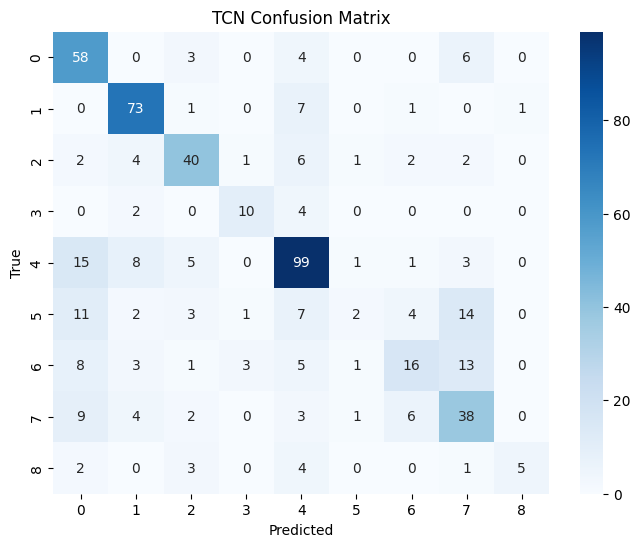

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_cls))

cm = confusion_matrix(y_test, y_pred_cls)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("TCN Confusion Matrix")
plt.show()


In [28]:
model.save("01_model.h5")


# TCN + CLASS WEIGHTS

In [29]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)


Class weights: {0: 0.8353535353535354, 1: 0.7123169681309216, 2: 1.0286069651741294, 3: 3.4894514767932487, 4: 0.4475108225108225, 5: 1.3513071895424837, 6: 1.1985507246376812, 7: 0.9344632768361582, 8: 3.8287037037037037}


In [30]:
history_w = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=16,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/60
156/156 [==============================] - 24s 147ms/step - loss: 0.9480 - accuracy: 0.7275 - val_loss: 1.1589 - val_accuracy: 0.6579 - lr: 6.2500e-05
Epoch 2/60
156/156 [==============================] - 23s 145ms/step - loss: 0.9107 - accuracy: 0.7142 - val_loss: 1.1675 - val_accuracy: 0.6579 - lr: 6.2500e-05
Epoch 3/60
156/156 [==============================] - 23s 145ms/step - loss: 0.9066 - accuracy: 0.7114 - val_loss: 1.1548 - val_accuracy: 0.6579 - lr: 6.2500e-05
Epoch 4/60
156/156 [==============================] - 23s 145ms/step - loss: 0.9064 - accuracy: 0.7118 - val_loss: 1.1676 - val_accuracy: 0.6523 - lr: 6.2500e-05
Epoch 5/60
156/156 [==============================] - 23s 145ms/step - loss: 0.9023 - accuracy: 0.7082 - val_loss: 1.1717 - val_accuracy: 0.6541 - lr: 6.2500e-05
Epoch 6/60
156/156 [==============================] - 23s 146ms/step - loss: 0.8999 - accuracy: 0.7179 - val_loss: 1.1730 - val_accuracy: 0.6579 - lr: 6.2500e-05
Epoch 7/60
156/156 [========

In [31]:
test_loss_w, test_acc_w = model.evaluate(X_test, y_test)
print("Test accuracy (with class weights):", test_acc_w)


17/17 [==============================] - 2s 89ms/step - loss: 1.1166 - accuracy: 0.6335
Test accuracy (with class weights): 0.63345867395401


In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred_w = model.predict(X_test)
y_pred_cls_w = np.argmax(y_pred_w, axis=1)

print(classification_report(y_test, y_pred_cls_w))


17/17 [==============================] - 2s 101ms/step
              precision    recall  f1-score   support

           0       0.56      0.72      0.63        71
           1       0.80      0.89      0.85        83
           2       0.70      0.69      0.70        58
           3       0.59      0.62      0.61        16
           4       0.78      0.71      0.74       132
           5       0.27      0.14      0.18        44
           6       0.53      0.36      0.43        50
           7       0.47      0.60      0.53        63
           8       0.33      0.40      0.36        15

    accuracy                           0.63       532
   macro avg       0.56      0.57      0.56       532
weighted avg       0.63      0.63      0.62       532



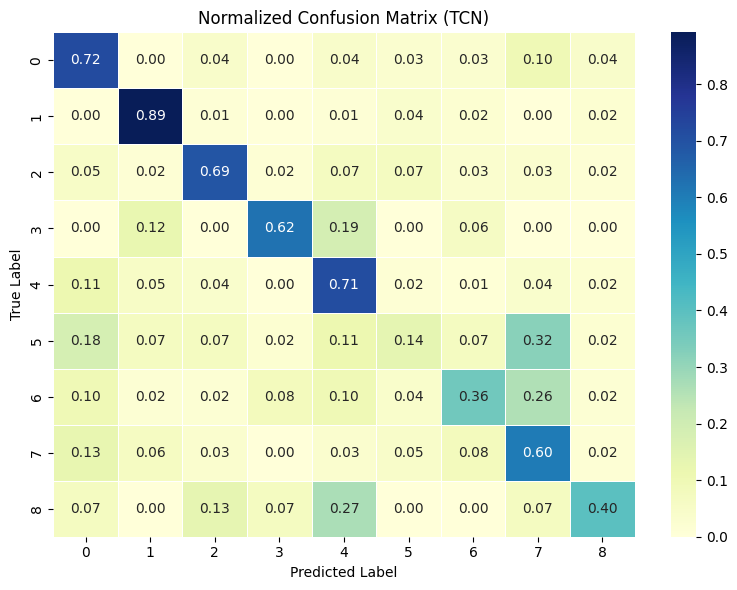

In [39]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="YlGnBu",
    linewidths=0.5
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (TCN)")
plt.tight_layout()
plt.show()


In [40]:
model.save("02_model.h5")


In [1]:
print('....')

....
